In [100]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import urllib.request
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

# Import the IMDb csv file for movies releasedbetween 1972- 2016
all_us_rel=pd.read_csv('All U.S. Released Movies_ 1972-2016.csv', engine='python')
# Need the Movie id to iterate through web pages to obtain technical detail
c_id= [x for x in all_us_rel['Const']]

In [2]:
# Creating a dataframe with technical descriptions and description of movie
# Import function from another ipynb file

def techdet(x):
    global df
    df=pd.DataFrame()
    for ids in x:
        # Get description of movie
        try:
            url1= 'https://www.imdb.com/title/{}/?ref_=ttls_li_tt'.format(ids)
            page1=bs(urllib.request.urlopen(url1),"html.parser")
            diction={}
            diction['Title']=ids
            diction['Description']=[x.text.strip() for x in page1.find_all('div', attrs={'class': re.compile( "summary_text")})][0]
            url= 'https://www.imdb.com/title/{}/technical?ref_=tt_dt_spec'.format(ids)
            page=bs(urllib.request.urlopen(url),"html.parser")
            # Technical specifications
            tech=[x.text.strip() for x in page.find_all('td', attrs={'class': re.compile( "label")})]
            # Details for Technical specifications
            details=[x.text.strip() for x in page.find_all('td')]

            for element in details:
                if element not in tech:
                    diction[details[details.index(element)-1]]= element
                elif element == 'Color':

                    diction['Color']= element
                else:
                    continue
            df=df.append(diction, ignore_index=True)
        except:
            pass

techdet(c_id)

# Ouput as a file to retrieve for later
df.to_csv('movie_details')
df=pd.read_csv('movie_details.csv')

In [113]:
# The 1972-2016 dataset
all_us_rel

,Position,Const,Created,Modified,Description,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,1,tt0110912,4/23/13,4/23/13,NaN,Pulp Fiction,https://www.imdb.com/title/tt0110912/,movie,8.9,154.0,1994.0,"Crime, Drama",1749330.0,5/21/94,Quentin Tarantino
1,2,tt1872181,4/23/13,4/23/13,NaN,The Amazing Spider-Man 2,https://www.imdb.com/title/tt1872181/,movie,6.6,142.0,2014.0,"Action, Adventure, Sci-Fi",404528.0,4/10/14,Marc Webb
2,3,tt0111161,4/23/13,4/23/13,NaN,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994.0,Drama,2231193.0,9/10/94,Frank Darabont
3,4,tt0076759,4/23/13,4/23/13,NaN,Star Wars,https://www.imdb.com/title/tt0076759/,movie,8.6,121.0,1977.0,"Action, Adventure, Fantasy, Sci-Fi",1186177.0,5/25/77,George Lucas
4,5,tt0088763,4/23/13,4/23/13,NaN,Back to the Future,https://www.imdb.com/title/tt0088763/,movie,8.5,116.0,1985.0,"Adventure, Comedy, Sci-Fi",996685.0,7/3/85,Robert Zemeckis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9936,9937,tt0775440,2/12/15,2/12/15,NaN,Cell,https://www.imdb.com/title/tt0775440/,movie,4.3,98.0,2016.0,"Action, Drama, Horror, Sci-Fi, Thriller",23839.0,5/19/16,Tod Williams
9937,9938,tt3748172,2/12/15,2/12/15,NaN,Gerald's Game,https://www.imdb.com/title/tt3748172/,movie,6.6,103.0,2017.0,"Drama, Horror, Thriller",79573.0,9/19/17,Mike Flanagan
9938,9939,tt3319460,2/12/15,2/12/15,NaN,Lisey's Story,https://www.imdb.com/title/tt3319460/,tvSeries,NaN,NaN,NaN,Drama,NaN,NaN,NaN
9939,9940,tt4425200,2/12/15,2/12/15,NaN,John Wick: Chapter 2,https://www.imdb.com/title/tt4425200/,movie,7.5,122.0,2017.0,"Action, Crime, Thriller",341164.0,1/30/17,Chad Stahelski


In [76]:
# Retrieve the output file
df=pd.read_csv('movie_details.csv')
df=df[['Title','Description']]
# Rename Title to Const to match Const column in all_us_rel
df.rename(columns={'Title':'Const'}, inplace=True)
# Merge on Const column
new=pd.merge(all_us_rel, df, on='Const')
new = new.assign(Description_x=new['Description_y'])
new = new[new.columns[:-1]]
new.rename(columns={'Description_x':'Description'},inplace=True)
new=new[['Title','Description','Genres']]
new = new[new['Genres'].notna()]
new = new.reset_index(drop=True)

In [78]:
# Clean the Text in Description
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text
# Split words by space and put into a list for each description
new['Clean'] = new['Description'].apply(lambda x: clean_text(x))

# Find all the unique genres in the set
allgenres=[]
for gen in new['Genres']:
    
    if ',' in gen:
        vals=[x.strip() for x in gen.split(',')]
        for y in vals:
            allgenres.append(y)
        
    else:
        allgenres.append(gen)
# Remove duplicates and turn set back into list
allgenres=list(set(allgenres))
allgenres=[x.lower() for x in allgenres]
allgenres

['history',
 'mystery',
 'romance',
 'sci-fi',
 'talk-show',
 'animation',
 'comedy',
 'western',
 'reality-tv',
 'musical',
 'news',
 'family',
 'horror',
 'action',
 'biography',
 'sport',
 'documentary',
 'adventure',
 'war',
 'short',
 'drama',
 'music',
 'fantasy',
 'thriller',
 'crime']

In [79]:
# Lowercase all the genres

def lowercasegenres(genres):
    for index in range(len(genres)):
        
        if 'Sci-Fi' in genres[index]:
            genres[index]=genres[index].replace('Sci-Fi', 'sci-fi')
            genres[index]=genres[index].lower()
        else:
            genres[index]=genres[index].lower()
            
# Remove all types of genres from the clean descriptions

def keyremove(x):
    for ind in range(len(x)):
        for gen in allgenres:
            if gen in x[ind]:
                x[ind]=x[ind].replace(gen,'')
            else:
                pass
lowercasegenres(new['Genres'])
keyremove(new['Clean'])



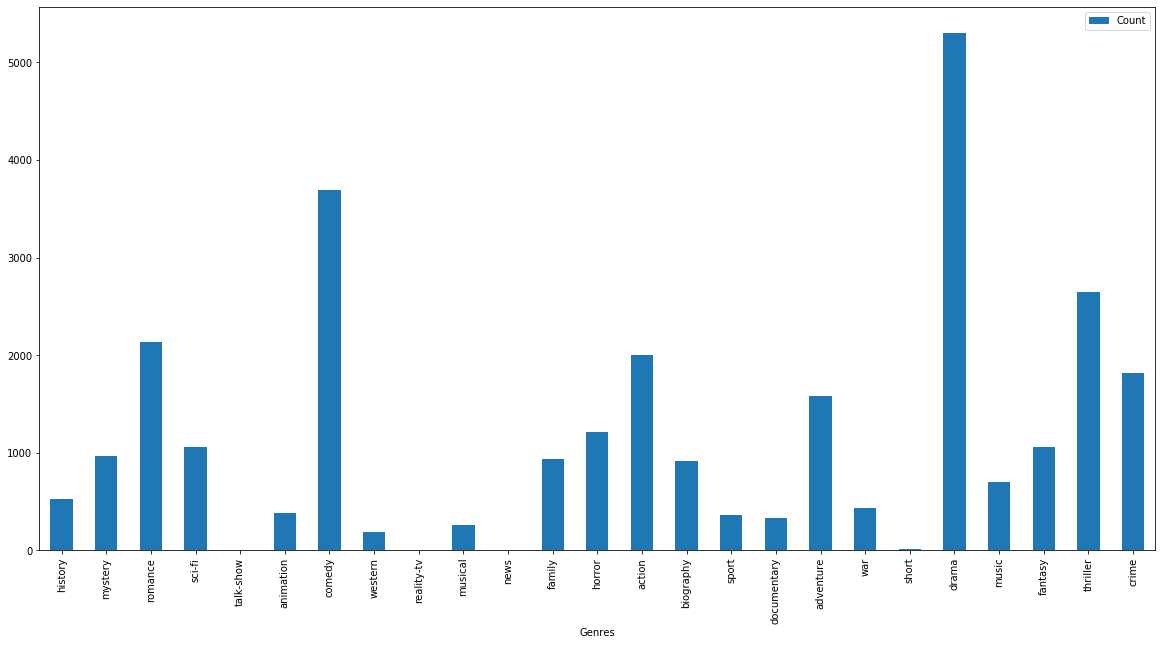

         Genres  Count
0       history    531
1       mystery    971
2       romance   2133
3        sci-fi   1056
4     talk-show      1
5     animation    383
6        comedy   3693
7       western    186
8    reality-tv      9
9       musical    257
10         news      9
11       family    936
12       horror   1214
13       action   2003
14    biography    920
15        sport    362
16  documentary    331
17    adventure   1580
18          war    434
19        short     19
20        drama   5305
21        music    697
22      fantasy   1064
23     thriller   2651
24        crime   1821


In [80]:
genres_1={'Genres': allgenres}
freq_count=pd.DataFrame(genres_1, columns=['Genres'])
count=[]
for x in allgenres:
    count.append(new.Genres.str.count(x).sum())
freq_count['Count']=count
# Plot frequency of each movie genre
freq_count.plot(x='Genres', y='Count', kind='bar', figsize=(20,10))
plt.show()
print(freq_count)

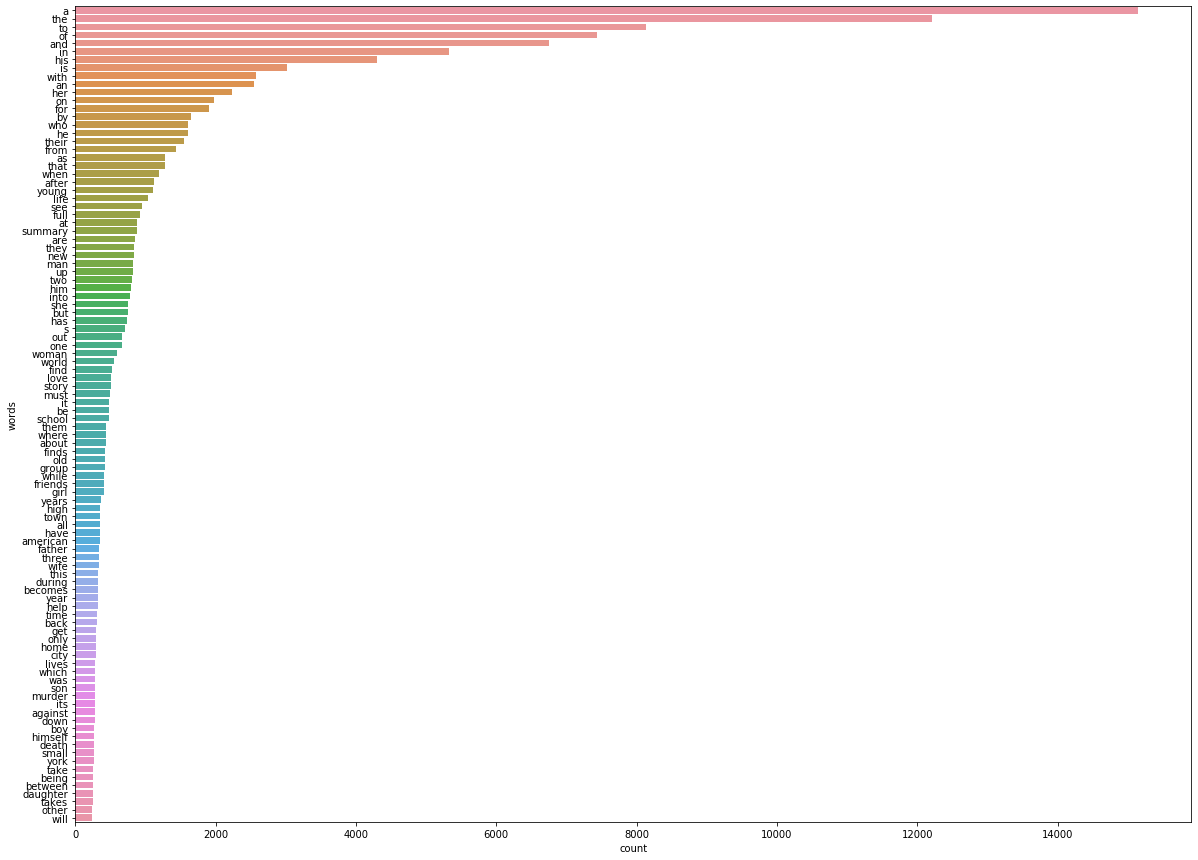

In [81]:
# find frequency of words in description

def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(20,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'words') 
    plt.show()
# print 100 most frequent words 
freq_words(new['Clean'], 100)

In [82]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

new['Clean'] = new['Clean'].apply(lambda x: remove_stopwords(x))
# Turn Genres into lists
def createlist(col):
    for x in range(len(col)):
        if ',' in col[x]:
            col[x]=col[x].replace(' ','').split(',')
        else:
            col[x]=[col[x]]
# Run createlist function once, else will make nested lists            
createlist(new['Genres'])
new['Genres']

0                                  [crime, drama]
1                     [action, adventure, sci-fi]
2                                         [drama]
3            [action, adventure, fantasy, sci-fi]
4                     [adventure, comedy, sci-fi]
                          ...                    
9810                    [drama, fantasy, mystery]
9811    [action, drama, horror, sci-fi, thriller]
9812                    [drama, horror, thriller]
9813                                      [drama]
9814                    [action, crime, thriller]
Name: Genres, Length: 9815, dtype: object

In [111]:
# Encode the Genres column
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(new['Genres'])
print(multilabel_binarizer.classes_)
# transform target variable
y = multilabel_binarizer.transform(new['Genres'])


['action' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'history' 'horror' 'music'
 'musical' 'mystery' 'news' 'reality-tv' 'romance' 'sci-fi' 'short'
 'sport' 'talk-show' 'thriller' 'war' 'western']


In [86]:
# Using TF-IDF to classify text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# Split dataset into training and validation set
# Leave the new['Clean'] column as text
X_train, X_test, y_train, y_test = train_test_split(new['Clean'], y, test_size=0.33, random_state=9)

Xtrain_tf = tfidf_vectorizer.fit_transform(X_train)
Xtesttf = tfidf_vectorizer.transform(X_test)


In [87]:
# Classifying the Data
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
# Fit model on train data
clf.fit(Xtrain_tf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [112]:
# Predict
y_pred = clf.predict(Xtesttf)
# Example
print(multilabel_binarizer.inverse_transform(y_pred)[0])
# Evaluate performance of classifier
print(f1_score(y_test, y_pred, average="micro"))
# Use the multiclass confusion matrix
print(multilabel_confusion_matrix(y_test, y_pred))

('drama',)
0.40854595757762063
[[[2545   32]
  [ 508  154]]

 [[2696   17]
  [ 470   56]]

 [[3104    0]
  [ 135    0]]

 [[2931   10]
  [ 269   29]]

 [[1814  211]
  [ 769  445]]

 [[2607   15]
  [ 478  139]]

 [[3124    0]
  [ 115    0]]

 [[ 922  574]
  [ 407 1336]]

 [[2916    0]
  [ 319    4]]

 [[2888    2]
  [ 337   12]]

 [[3058    0]
  [ 181    0]]

 [[2828    1]
  [ 382   28]]

 [[3096    0]
  [ 139    4]]

 [[3148    0]
  [  91    0]]

 [[2911    2]
  [ 321    5]]

 [[3235    0]
  [   4    0]]

 [[3235    0]
  [   4    0]]

 [[2508   49]
  [ 544  138]]

 [[2884    3]
  [ 301   51]]

 [[3230    0]
  [   9    0]]

 [[3123    0]
  [ 105   11]]

 [[3238    0]
  [   1    0]]

 [[2298   72]
  [ 629  240]]

 [[3101    1]
  [ 131    6]]

 [[3181    0]
  [  58    0]]]


In [48]:
rfc=RandomForestClassifier(random_state=3)
rfc.fit(Xtrain_tf, y_train)
y_pred1 = rfc.predict(Xtesttf)
f1= f1_score(y_test, y_pred1, average="micro") 
print(f1)
print(multilabel_binarizer.inverse_transform(y_pred1)[0])
print(multilabel_confusion_matrix(y_test, y_pred1))

0.3997618693257925
('drama',)
[[[2554   23]
  [ 578   84]]

 [[2709    4]
  [ 498   28]]

 [[3104    0]
  [ 134    1]]

 [[2925   16]
  [ 274   24]]

 [[1720  305]
  [ 761  453]]

 [[2571   51]
  [ 445  172]]

 [[3123    1]
  [ 112    3]]

 [[ 694  802]
  [ 339 1404]]

 [[2916    0]
  [ 320    3]]

 [[2889    1]
  [ 343    6]]

 [[3057    1]
  [ 179    2]]

 [[2823    6]
  [ 379   31]]

 [[3094    2]
  [ 129   14]]

 [[3148    0]
  [  90    1]]

 [[2913    0]
  [ 319    7]]

 [[3235    0]
  [   4    0]]

 [[3235    0]
  [   4    0]]

 [[2488   69]
  [ 524  158]]

 [[3234    0]
  [   5    0]]

 [[2887    5]
  [ 290   57]]

 [[3230    0]
  [   9    0]]

 [[3121    2]
  [ 105   11]]

 [[3238    0]
  [   1    0]]

 [[2274   96]
  [ 650  219]]

 [[3099    3]
  [ 132    5]]

 [[3181    0]
  [  55    3]]]


In [49]:
knn=KNeighborsClassifier(n_neighbors = 23)
knn.fit(Xtrain_tf, y_train)

y_pred2=knn.predict(Xtesttf)
f1_2=f1_score(y_test, y_pred2, average="micro")
print(f1_2)
print(multilabel_binarizer.inverse_transform(y_pred2)[0])
print(multilabel_confusion_matrix(y_test, y_pred2))

0.37817788424387605
('drama',)
[[[2557   20]
  [ 560  102]]

 [[2711    2]
  [ 490   36]]

 [[3104    0]
  [ 135    0]]

 [[2939    2]
  [ 286   12]]

 [[1828  197]
  [ 809  405]]

 [[2602   20]
  [ 514  103]]

 [[3124    0]
  [ 114    1]]

 [[ 737  759]
  [ 343 1400]]

 [[2915    1]
  [ 319    4]]

 [[2888    2]
  [ 341    8]]

 [[3058    0]
  [ 181    0]]

 [[2825    4]
  [ 383   27]]

 [[3095    1]
  [ 134    9]]

 [[3148    0]
  [  91    0]]

 [[2913    0]
  [ 322    4]]

 [[3235    0]
  [   4    0]]

 [[3235    0]
  [   4    0]]

 [[2520   37]
  [ 605   77]]

 [[3234    0]
  [   5    0]]

 [[2889    3]
  [ 306   41]]

 [[3230    0]
  [   9    0]]

 [[3122    1]
  [ 101   15]]

 [[3238    0]
  [   1    0]]

 [[2290   80]
  [ 673  196]]

 [[3102    0]
  [ 130    7]]

 [[3181    0]
  [  58    0]]]
